In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
data_dir = "/home/wubbalubba/DL/Datasets"

train_dir = data_dir + "/train"
dev_dir = data_dir + "/dev"
test_dir = data_dir + "/test"

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize(500),
    transforms.RandomCrop(227),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

dev_transforms = transforms.Compose([
    transforms.Resize(500),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(500),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

check_transforms = transforms.Compose([
    transforms.Resize(400),
])

In [4]:
train_ds = datasets.ImageFolder(train_dir,transform=train_transforms)

#dev_ds = datasets.ImageFolder(dev_dir,transform=dev_transforms)

test_ds = datasets.ImageFolder(test_dir,transform=test_transforms)

check_ds = datasets.ImageFolder(test_dir, transform=check_transforms)

In [5]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight  

In [6]:
weights = make_weights_for_balanced_classes(train_ds.imgs, len(train_ds.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle = False, sampler = sampler) 

/home/wubbalubba/anaconda3/lib/python3.6/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


In [7]:
from torch.utils.data import DataLoader

In [8]:
train_dl = DataLoader(train_ds, batch_size = 4, shuffle = True)

#dev_dl = DataLoader(dev_ds, batch_size = 2, shuffle = False)

test_dl = DataLoader(test_ds, batch_size = 4, shuffle = False)

check_dl = DataLoader(check_ds, batch_size = 1, shuffle = False)

In [9]:
train_iter = iter(train_dl)
X, y = next(train_iter)
print("X: {} \ny: {}".format(X.shape,y.shape))
train_dl.dataset

X: torch.Size([1, 3, 227, 227]) 
y: torch.Size([1])


Dataset ImageFolder
    Number of datapoints: 50
    Root Location: /home/wubbalubba/DL/Datasets/train
    Transforms (if any): Compose(
                             Resize(size=500, interpolation=PIL.Image.BILINEAR)
                             RandomCrop(size=(227, 227), padding=None)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [10]:
N_epochs = 10

In [11]:
model = models.alexnet(pretrained=True)

In [12]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [13]:
def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)

def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)

def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)

def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False

In [14]:
freeze_all(model.parameters())
assert all_frozen(model.parameters())

In [15]:
classifier = list(model.classifier.children())
model.classifier = nn.Sequential(*classifier[:-1])
model.classifier.add_module('6', nn.Linear(classifier[-1].in_features, out_features=2048))
model.classifier.add_module('7', nn.Linear(2048, out_features=2))

In [16]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
optimizer = torch.optim.Adam(
    get_trainable(model.parameters()),
    lr=0.001,
    # momentum=0.9,
)

In [19]:
N_EPOCHS = 25
train_loss = []
valid_loss = []
for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    
    # Train
    model.train()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    for X, y in train_dl:
        
        
        optimizer.zero_grad()
        y_ = model(X)
        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()
        
        # Statistics
        #print(f"    batch loss: {loss.item():0.3f}")
        _, y_label_ = torch.max(y_, 1)
        correct += (y_label_ == y).sum().item()
        running_loss += loss.item() * X.shape[0]
    
    print(f"  Train Loss: {running_loss / len(train_dl.dataset)}")
    print(f"  Train Acc:  {correct / len(train_dl.dataset)}")
    train_loss.append([epoch,running_loss / len(train_dl.dataset)])
    
    # Eval
    model.eval()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    with torch.no_grad():  # IMPORTANT
        for X, y in test_dl:
            
                    
            y_ = model(X)
        
            # Statistics
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
    
    print(f"  Valid Loss: {running_loss / len(test_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(test_dl.dataset)}")
    valid_loss.append([epoch,running_loss / len(train_dl.dataset)])

Epoch 1/25
  Train Loss: 4.827928052693605
  Train Acc:  0.78
  Valid Loss: 0.33232290546099347
  Valid Acc:  0.9
Epoch 2/25
  Train Loss: 0.7730217072367668
  Train Acc:  0.9
  Valid Loss: 1.1474213918050131
  Valid Acc:  0.9
Epoch 3/25
  Train Loss: 0.7843486821651459
  Train Acc:  0.88
  Valid Loss: 0.006474322080612183
  Valid Acc:  1.0
Epoch 4/25
  Train Loss: 0.13108807563781738
  Train Acc:  0.98
  Valid Loss: 0.17624467511971792
  Valid Acc:  0.9666666666666667
Epoch 5/25
  Train Loss: 0.8928741073608398
  Train Acc:  0.9
  Valid Loss: 1.348931301633517
  Valid Acc:  0.8333333333333334
Epoch 6/25
  Train Loss: 0.710661712884903
  Train Acc:  0.92
  Valid Loss: 0.11484323342641195
  Valid Acc:  0.9666666666666667
Epoch 7/25
  Train Loss: 2.2708189344406127
  Train Acc:  0.86
  Valid Loss: 0.7471091032028199
  Valid Acc:  0.9
Epoch 8/25
  Train Loss: 4.098529422283173
  Train Acc:  0.86
  Valid Loss: 0.00010259151458740235
  Valid Acc:  1.0
Epoch 9/25
  Train Loss: 0.667080074548

In [20]:
test_dl = DataLoader(test_ds, batch_size = len(test_ds), shuffle = False)
with torch.no_grad():# IMPORTANT
    running_loss, correct = 0.0, 0
    for X, y in test_dl:
            
            y_ = model(X)
        
            # Statistics
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
            
    F1ScoreMicro = f1_score(y, y_label_, average="micro")
    F1ScoreMacro = f1_score(y, y_label_, average="macro")
    F1ScoreWeighted = f1_score(y, y_label_, average="weighted")
    print(f"F1-score micro: {F1ScoreMicro}")
    print(f"F1-score macro: {F1ScoreMacro}")
    print(f"F1-score weighted: {F1ScoreWeighted}")
    print(f"  Valid Loss: {running_loss / len(test_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(test_dl.dataset)}")
    print(y)
    print(y_label_)

F1-score micro: 1.0
F1-score macro: 1.0
F1-score weighted: 1.0
  Valid Loss: 0.0
  Valid Acc:  1.0
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


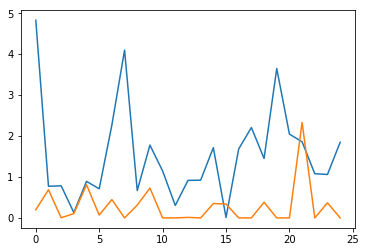

In [21]:
trl = np.asarray(train_loss)
tsl = np.asarray(valid_loss)
plt.plot(trl[:,0],trl[:,1],tsl[:,0],tsl[:,1])